In [10]:
# auto reload

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from dsd import DATA_DIR
from dsd.diffusion_rendering import * 




In [12]:
image_dir = DATA_DIR / "renders/mugs/10/ACE_Coffee_Mug_Kristen/000"
input_images = DiffusionRenderInputImages.from_render_dir(image_dir)
#input_images.depth_image[input_images.depth_image > 1.0] = 1.0


In [13]:
print(input_images.depth_image.shape)
print(input_images.depth_image[0,200])
print(input_images.depth_image.dtype)
print(input_images.get_rgb_image_torch().shape)
print(input_images.rgb_image[100,100])



(512, 512)
3.0
float32
torch.Size([1, 3, 512, 512])
[0.60784316 0.60784316 0.60784316]


In [14]:
canny_edges = get_canny_edges_from_image(input_images.rgb_image,20,100)
inverted_depth = input_images.get_inverted_depth_image()
normals = input_images.get_normal_map()
depth_canny_edges = get_canny_edges_from_image(inverted_depth,20,100)

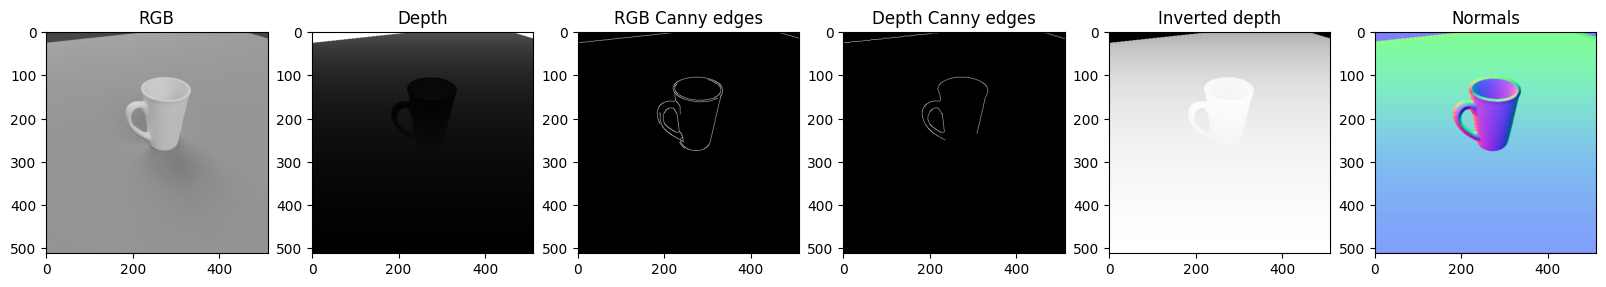

In [15]:
# plot original image and depth, as well as the processed images 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 6, figsize=(20, 5))
axes[0].imshow(input_images.rgb_image)
axes[0].set_title("RGB")
axes[1].imshow(input_images.depth_image, cmap="gray")
axes[1].set_title("Depth")
axes[2].imshow(canny_edges, cmap="gray")
axes[2].set_title("RGB Canny edges")
axes[3].imshow(depth_canny_edges, cmap="gray")
axes[3].set_title("Depth Canny edges")
axes[4].imshow(inverted_depth, cmap="gray")
axes[4].set_title("Inverted depth")
axes[5].imshow(normals)
axes[5].set_title("Normals")


plt.show()


In [16]:
import matplotlib.pyplot as plt
def visualize_results(rgb,control, images):
    # plot original image and depth, as well as the processed images
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    axes[0].imshow(rgb)
    axes[0].set_title("RGB")
    axes[1].imshow(control)
    axes[1].set_title("Control Image")
    axes[2].imshow(images[0])
    axes[2].set_title("prompted")
    axes[3].imshow(images[1])
    axes[3].set_title("prompted")
    axes[4].imshow(images[2])
    axes[4].set_title("prompted")
    axes[5].imshow(images[3])
    axes[5].set_title("prompted")
    plt.show()


In [27]:
strength = 0.6
controlnet_conditioning_scale = 1.3
n_steps = 5

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

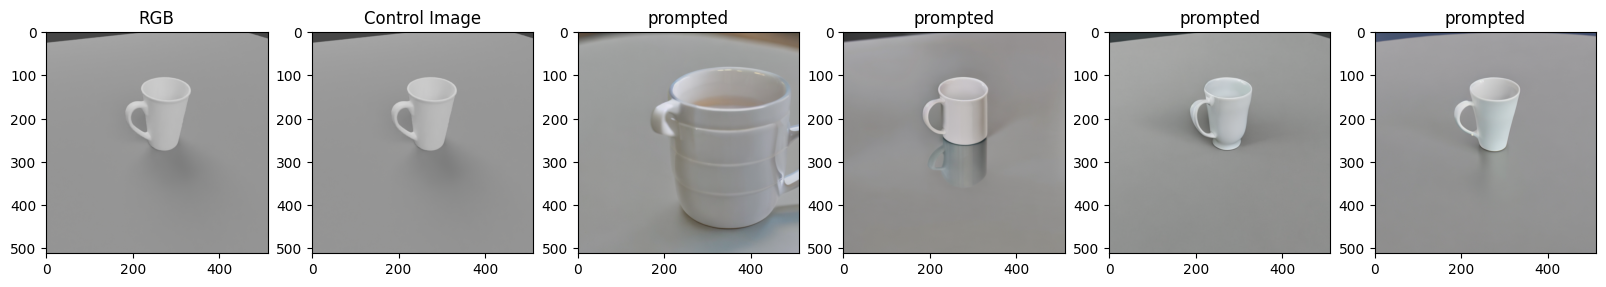

In [28]:

renderer = ControlNetTXTFromDepthRenderer(num_inference_steps=50,controlnet_conditioning_scale=controlnet_conditioning_scale,strength=strength)
images = renderer(["a blue  mug, photorealistic, DSLR, ambient lighting, high contrast, 4K"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

In [ ]:
cropped_images = ObjectCroppedDiffusionRenderInputImages(input_images)
images = renderer(["a blue striped mug, photorealistic, DSLR, ambient lighting, high contrast, 4K"], cropped_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

In [ ]:
from dsd.cropped_diffusion_rendering import CroppedRenderer, ObjectCroppedDiffusionRenderInputImages
cropped_renderer = CroppedRenderer(renderer)
images = cropped_renderer(["a blue striped mug, photorealistic, DSLR, ambient lighting, high contrast, 4K"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

In [ ]:
input_images.rgb_image = np.array(images[0]).astype(np.float32) / 255.0
input_images.mask = 1- input_images.mask

In [ ]:

inpaint_renderer = SD2InpaintingRenderer(num_inference_steps=50,strength=0.9)
images = inpaint_renderer(" a kitchen table with books", input_images)
visualize_results(input_images.rgb_image, input_images.mask,images)

In [ ]:
renderer = ControlNetFromDepthRenderer(num_inference_steps=50,controlnet_conditioning_scale=controlnet_conditioning_scale,strength=strength)
images = renderer(["a blue and orange mug, photorealistic, DSLR, ambient lighting, high contrast, 4K"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

In [ ]:
renderer = SD2InpaintingRenderer(num_inference_steps=50,strength=0.8)
images = renderer("a steel mug", input_images)
visualize_results(input_images.rgb_image,input_images.mask,images)


In [ ]:
renderer = SD2FromDepthRenderer()
renderer.strength = 0.7
renderer.num_images_per_prompt = 4
images = renderer("steel mug mug", input_images)

visualize_results(input_images.rgb_image,input_images.get_inverted_depth_image(),images)


In [ ]:
#renderer = SDXLControlNetTXTFromDepthRenderer(num_inference_steps=50,controlnet_conditioning_scale=controlnet_conditioning_scale,strength=strength)
images = renderer(["a green mug on a blue surface, photorealistic, 4K"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)

In [ ]:
renderer = SDXLControlNetFromCannyRenderer(num_inference_steps=50,controlnet_conditioning_scale=1.0,strength=strength)

In [ ]:
renderer.num_inference_steps = 30
renderer.controlnet_conditioning_scale = 1.0
images = renderer(["a mug on a blue surface, photorealistic, 4K"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images),images)

In [ ]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2

prompt = "aerial view, a futuristic research complex in a bright foggy jungle, hard lighting"
negative_prompt = 'low quality, bad quality, sketches'

image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png")

controlnet_conditioning_scale = 0.5  # recommended for good generalization

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()

image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)



In [ ]:
image = input_images.get_rgb_image_torch()


images = pipe(
    prompt, negative_prompt=negative_prompt, image=image, controlnet_conditioning_scale=controlnet_conditioning_scale,
    ).images

images[0].save(f"hug_lab.png")


In [ ]:
renderer = ControlnetfromHEDRenderer(num_inference_steps=50,controlnet_conditioning_scale=controlnet_conditioning_scale)
images = renderer(["a rainbow mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images),images)

In [ ]:
renderer.get_logging_name()

In [ ]:
renderer = ControlNetFromCannyRenderer(num_inference_steps=n_steps,controlnet_conditioning_scale=controlnet_conditioning_scale, strength = strength)
images = renderer(["a colorful mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images),images)

In [ ]:
renderer = ControlNetFromNormalsRenderer(num_inference_steps=n_steps,controlnet_conditioning_scale=controlnet_conditioning_scale, strength = strength)
images = renderer(["a colorful mug on a blue surface"], input_images)
visualize_results(input_images.rgb_image, renderer.get_control_image(input_images)[0].numpy().transpose(1,2,0),images)